In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
random_seed = 0

L = 
[[1 0 0]
 [1 1 0]
 [1 1 1]]
M = 
[[1 0 0]
 [2 1 0]
 [2 1 2]]
Theoretical AW_2^2:  3.0


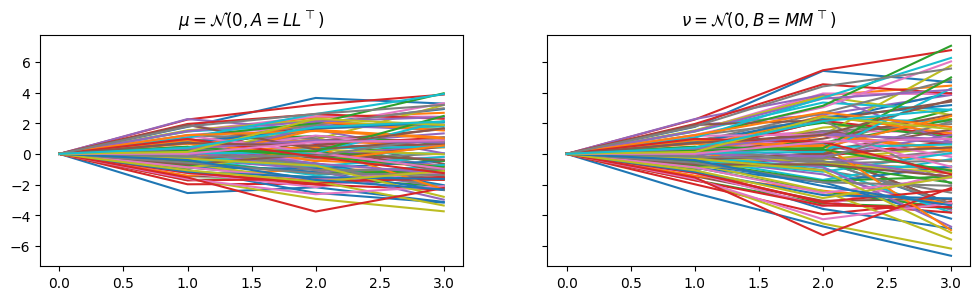

In [2]:
from pnot.utils import adapted_wasserstein_squared, matrixL2paths

n_sample = 100
T = 3

L = np.array([[1, 0, 0], [1, 1, 0], [1, 1, 1]])
X ,A = matrixL2paths(L, n_sample, seed = random_seed)
print('L = ')
print(L)

M = np.array([[1, 0, 0], [2, 1, 0], [2, 1, 2]])
Y,B = matrixL2paths(M, n_sample, seed = random_seed)
print('M = ')
print(M)

awd2square = adapted_wasserstein_squared(A, B)
print("Theoretical AW_2^2: ", awd2square)

fig, ax = plt.subplots(1,2, figsize = [12,3], sharey=True)
ax[0].plot(X[:,:100])
ax[1].plot(Y[:,:100])
ax[0].set_title(r'$\mu = \mathcal{N}(0,A = LL^\top)$')
ax[1].set_title(r'$\nu = \mathcal{N}(0,B = MM^\top)$')
plt.show()

In [ ]:
from pnot import nested_ot

n_sample = 20000
X,A = matrixL2paths(L, n_sample, seed = random_seed)
Y,B = matrixL2paths(M, n_sample, seed = random_seed)

grid_size = 0.1

print('Markovian')
print("="*200)
ot_value_markovian = nested_ot(X, Y, grid_size, markovian = True, num_threads=16, verbose = True)
print(" "*200)

print('Non-Markovian')
print("="*200)
ot_value = nested_ot(X, Y, grid_size, markovian = False, num_threads=16, verbose = True)

Markovian
Start computing with 16 threads
Timestep 2
Computing 16224 OTs .......
Timestep 1
Computing 5625 OTs .......
Timestep 0
Computing 1 OTs .......
0.936912 seconds
Nested OT value: 3.02613
Finish
                                                                                                                                                                                                        
Non-Markovian
Start computing with 16 threads
Timestep 2
Computing 6438816 OTs .......
Timestep 1
Computing 5625 OTs .......
Timestep 0
Computing 1 OTs .......
12.4632 seconds
Nested OT value: 3.20105
Finish


# What is going on when you call the nested_ot?

## Step 1: the paths are mapped to a grid with size grid_size

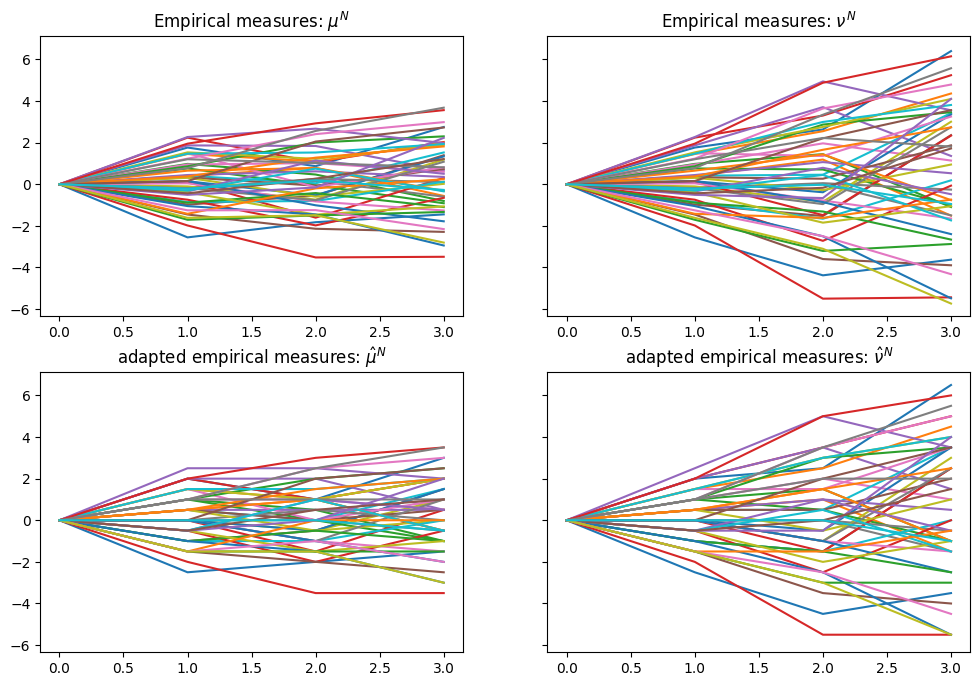

In [5]:
from pnot.utils import path2adaptedpath

n_sample = 50
X,A = matrixL2paths(L, n_sample, seed = random_seed)
Y,B = matrixL2paths(M, n_sample, seed = random_seed)

grid_size = 0.5
adaptedX = path2adaptedpath(X, grid_size)
adaptedY = path2adaptedpath(Y, grid_size)


fig, ax = plt.subplots(2,2, figsize = [12,8], sharey=True)
ax[0,0].plot(X[:,:100])
ax[0,1].plot(Y[:,:100])
ax[0,0].set_title(r'Empirical measures: $\mu^N$')
ax[0,1].set_title(r'Empirical measures: $\nu^N$')

ax[1,0].plot(adaptedX[:,:100])
ax[1,1].plot(adaptedY[:,:100])
ax[1,0].set_title(r'adapted empirical measures: $\hat{\mu}^N$')
ax[1,1].set_title(r'adapted empirical measures: $\hat{\nu}^N$')
plt.show()


## Step 2: the values are quantized by a bijection to non-negative integers

In [6]:
# Quantization map
from pnot.utils import sort_qpath

q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
v2q = {k: v for v, k in enumerate(q2v)}  # Value to Quantization

# Quantized paths
qX = np.array([[v2q[x] for x in y] for y in adaptedX])
qY = np.array([[v2q[x] for x in y] for y in adaptedY])

# Sort paths and transpose to (n_sample, T+1)
qX = sort_qpath(qX.T)
qY = sort_qpath(qY.T)

print('adaptedX: ')
print(adaptedX.T[:10])

print('qX: ')
print(qX[:10])


adaptedX: 
[[ 0.   2.   1.   3. ]
 [ 0.   0.5  1.  -0.5]
 [ 0.   1.   0.5 -1. ]
 [ 0.   2.   1.   2. ]
 [ 0.   2.   2.   0.5]
 [ 0.  -1.  -0.5  1.5]
 [ 0.   1.   1.   0.5]
 [ 0.   0.   0.  -0.5]
 [ 0.   0.  -0.5  1. ]
 [ 0.   0.5  0.   1.5]]
qX: 
[[10  5  6  7]
 [10  6  3  3]
 [10  7  6  5]
 [10  7  7  4]
 [10  7  7  7]
 [10  7  8  6]
 [10  7 10 10]
 [10  8  7  4]
 [10  8  8 10]
 [10  8  9  8]]


## Step 3: calculate the conditional distributions of qX

In [7]:
from pnot.py_solver import ConditionalLaw
from pnot.utils import qpath2mu_x

# If we use markovian = True here, then the condition is the last value of history path: (x_t,)
# If we use markovian = False here, the condition is the whole history path: (x_0, ..., x_t,)
mu_x_markovian = qpath2mu_x(qX, markovian = True)
mu_x = qpath2mu_x(qX, markovian = False)

def print_mu_x(mu_x):
    for t in range(T):
        print(f"Timestep: {t}")
        for ix, item in enumerate(mu_x[t].items()):
            condition, distribution = item
            print("Condition:")
            print(condition)
            print("Distribution: ")
            print(distribution) # distribution is a dictionary = {next_value : counts} 
            if ix > 5:
                print("."*10)
                break
        print("*"*100)

print('Markovian')
print("="*200)
print_mu_x(mu_x_markovian)

print('Non-Markovian')
print("="*200)
print_mu_x(mu_x)

Markovian
Timestep: 0
Condition:
(10,)
Distribution: 
{5: 1, 6: 1, 7: 5, 8: 4, 9: 6, 10: 10, 11: 7, 12: 7, 13: 4, 14: 4, 15: 1}
****************************************************************************************************
Timestep: 1
Condition:
(5,)
Distribution: 
{6: 1}
Condition:
(6,)
Distribution: 
{3: 1}
Condition:
(7,)
Distribution: 
{6: 1, 7: 2, 8: 1, 10: 1}
Condition:
(8,)
Distribution: 
{7: 1, 8: 1, 9: 2}
Condition:
(9,)
Distribution: 
{6: 1, 7: 1, 10: 1, 11: 1, 12: 2}
Condition:
(10,)
Distribution: 
{7: 1, 8: 3, 9: 2, 10: 2, 11: 1, 14: 1}
Condition:
(11,)
Distribution: 
{9: 1, 10: 2, 11: 1, 12: 2, 13: 1}
..........
****************************************************************************************************
Timestep: 2
Condition:
(6,)
Distribution: 
{7: 1, 5: 1, 9: 1}
Condition:
(3,)
Distribution: 
{3: 1}
Condition:
(7,)
Distribution: 
{4: 2, 7: 1, 8: 1, 11: 1}
Condition:
(8,)
Distribution: 
{6: 2, 10: 1, 7: 1, 12: 1}
Condition:
(10,)
Distribution: 
{10: 1, 14: 1

## Step 4: Generate all we need to solve the Nested OT

In [8]:
kernel_x_markovian = ConditionalLaw(qX, True)
kernel_x = ConditionalLaw(qX, False)
kernel_y_markovian = ConditionalLaw(qY, True)
kernel_y = ConditionalLaw(qY, False)

def print_kernel_x(kernel_x):
    c, nc, v, w, next_idx = kernel_x.c, kernel_x.nc, kernel_x.v, kernel_x.w, kernel_x.next_idx
    for t in range(T):
        print(f"Timestep: {t}")
        for ix in range(nc[t]):
            condition = c[t][ix]
            values = v[t][ix]
            weights = w[t][ix]
            print("Condition: ", condition)
            print("Values: ", values)
            if t < T-1:
                values_idx = next_idx[t][ix]
                print("Values' indices: ", values_idx )
            print("Weights:", weights)
            # distribution is a dictionary = {next_value : counts} 
            if ix > 5:
                print("."*10)
                break
        print("*"*100)

print('Markovian')
print("="*200)
print_kernel_x(kernel_x_markovian)

print('Non-Markovian')
print("="*200)
print_kernel_x(kernel_x)

Markovian
Timestep: 0
Condition:  (10,)
Values:  [ 5  6  7  8  9 10 11 12 13 14 15]
Values' indices:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Weights: [0.02 0.02 0.1  0.08 0.12 0.2  0.14 0.14 0.08 0.08 0.02]
****************************************************************************************************
Timestep: 1
Condition:  (5,)
Values:  [6]
Values' indices:  [0]
Weights: [1.]
Condition:  (6,)
Values:  [3]
Values' indices:  [1]
Weights: [1.]
Condition:  (7,)
Values:  [ 6  7  8 10]
Values' indices:  [0, 2, 3, 4]
Weights: [0.2 0.4 0.2 0.2]
Condition:  (8,)
Values:  [7 8 9]
Values' indices:  [2, 3, 5]
Weights: [0.25 0.25 0.5 ]
Condition:  (9,)
Values:  [ 6  7 10 11 12]
Values' indices:  [0, 2, 4, 6, 7]
Weights: [0.16666667 0.16666667 0.16666667 0.16666667 0.33333333]
Condition:  (10,)
Values:  [ 7  8  9 10 11 14]
Values' indices:  [2, 3, 5, 4, 6, 8]
Weights: [0.1 0.3 0.2 0.2 0.1 0.1]
Condition:  (11,)
Values:  [ 9 10 11 12 13]
Values' indices:  [5, 4, 6, 7, 9]
Weights: [0.14285714 0.285

## Step 5: Solve the Nested OT backward

In [9]:
from pnot.py_solver import ot_solver
from tqdm import tqdm
cost_matrix = np.square(q2v[:,None] - q2v[None,:])
T = kernel_x.T
V = [
    np.zeros([kernel_x.nc[t], kernel_y.nc[t]]) for t in range(T)
]  # V_t(x_{1:t},y_{1:t})
for t in range(T - 1, -1, -1):
    x_bar = tqdm(range(kernel_x.nc[t]))
    x_bar.set_description(f"Timestep {t}")
    for ix in x_bar:
        for iy in range(kernel_y.nc[t]):
            vx = kernel_x.v[t][ix]
            vy = kernel_y.v[t][iy]
            wx = kernel_x.w[t][ix]
            wy = kernel_y.w[t][iy]
            cost = cost_matrix[np.ix_(vx, vy)]
            if t < T - 1:
                x_next_idx = kernel_x.next_idx[t][ix]
                y_next_idx = kernel_y.next_idx[t][iy]
                cost += V[t + 1][np.ix_(x_next_idx, y_next_idx)]
            V[t][ix, iy] = ot_solver(wx, wy, cost)
nested_ot_value = V[0][0, 0]
print("Nested OT value: ", nested_ot_value)

Timestep 0: 100%|██████████| 1/1 [00:00<00:00, 644.78it/s]

Nested OT value:  4.480833333333333
